# K-means Clustering

One of the most popular clustering algorithms, where similarity between clusters is computed in terms of a distance measure, most commonly Euclidean distance.

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import time

import matplotlib.pyplot as plt 

import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin

from IPython import display # For live plotting with Jupyter notebook

np.set_printoptions(suppress=True)

np.random.seed(13)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

To begin with, let's generate a data cloud for illustration:

Text(0.5, 1.0, 'True Gaussian Component Labels')

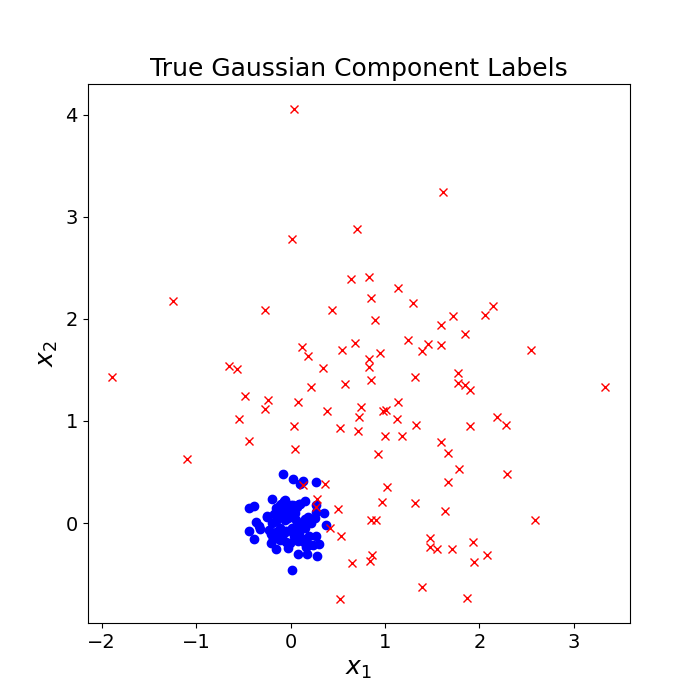

In [2]:
# Number of samples to draw from two Gaussian "data clouds"
N1 = 100
N2 = 100

n = 2 # Dimensionality of data

mu1 = np.zeros(n)
Sigma1 = 0.2**2 * np.identity(n)
X1 = multivariate_normal.rvs(mu1, Sigma1, N1)

mu2 = np.ones(n)
Sigma2 = 0.9**2 * np.identity(n)
X2 = multivariate_normal.rvs(mu2, Sigma2, N2)

fig = plt.figure(figsize=(7, 7))
plt.plot(X1[:, 0], X1[:, 1], 'bo')
plt.plot(X2[:, 0], X2[:, 1], 'rx')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("True Gaussian Component Labels")

Given this data cloud, we now aim to decipher coherent clusters by optimizing the objective function of K-means, also known as the <b>distortion function</b>:

\begin{equation*}
\mathcal{J}(c, \boldsymbol{\mu}) = \sum_{i=1}^N || \mathbf{x}^{(i)} - \boldsymbol{\mu}_{c^{(i)}} ||^2_2,
\end{equation*}

where $\mathcal{J}$ is the distortion function, $c^{(i)}$ is the assigned cluster label for sample $\mathbf{x}^{(i)}$, and $\boldsymbol{\mu}_{c^{(i)}}$ is the cluster centroid to which this sample has been assigned. The distortion objective is thus defined as the sum of squared distances between each sample and its dominating centroid.

K-means optimizes this objective using <b>alternating minimization</b> via two steps:

1) <b>Cluster assignment</b> – for every $i$

\begin{equation*}
c^{(i)}= \mathop{\rm argmin}_k ||\mathbf{x}^{(i)} - \boldsymbol{\mu}_k||^2_2.
\end{equation*}

2) <b>Mean update</b> – for every $k$

\begin{equation*}
\boldsymbol{\mu}_k= \frac{1}{N_k} \sum_{i:c^{(i)}=k} \mathbf{x}^{(i)},
\end{equation*}

where $N_k = |\{c^{(i)} = k\}|$ are the number of samples assigned to cluster $k$.

These two steps are "alternating minimization" in the sense that the K-means algorithm is repeatedly minimizing $\mathcal{J}$ with respect to $c$ while holding $\boldsymbol{\mu}$ constant, and then repeatedly minimizing $\mathcal{J}$ with respect to $\boldsymbol{\mu}$ while holding $c$ fixed. Using this approach, K-means will find a local minimum of $\mathcal{J}(c, \boldsymbol{\mu})$.

Note that K-means is an iterative algorithm, such that each of these steps has an associated iteration/time index $t$, hence the "repeatedly" aspect.

Below we implement this algorithm on the above data cloud, assuming $K=2$ and unlabeled data:

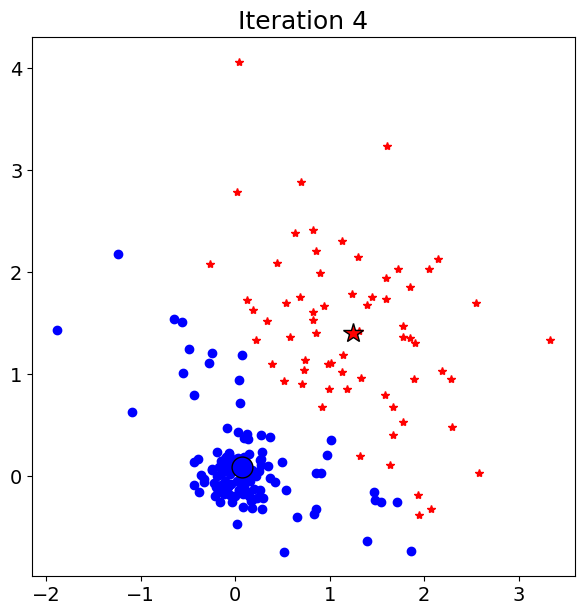

Text(0.5, 1.0, 'K-means Clustering Labels')

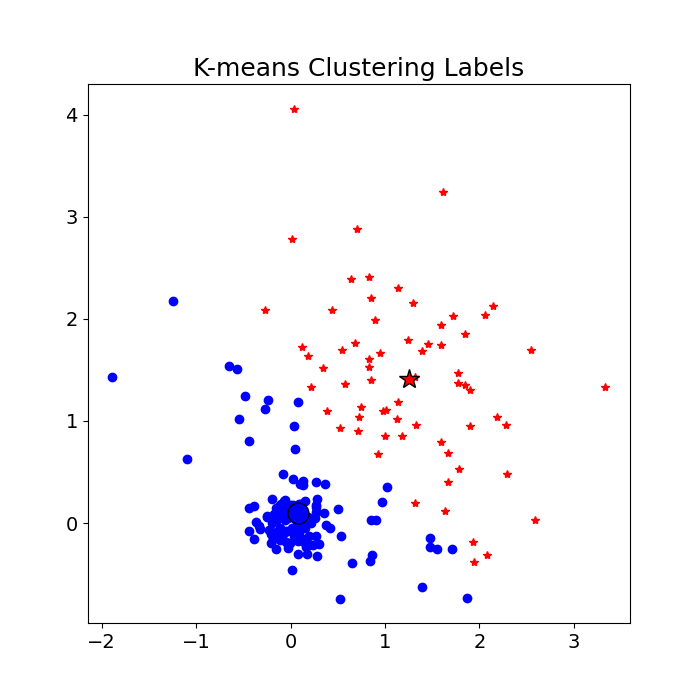

In [3]:
X = np.concatenate((X1, X2))
N = N1 + N2

fig = plt.figure(figsize=(7, 7))

plt.plot(X[:, 0], X[:, 1], 'b.')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")

### K-means Algorithm ###
def k_means_clustering(X, centroids, plot=True):
    # Convergence when values no longer change, can compare centroids
    converged = False
    # K-means iteration index
    t = 0
    while not converged:
        centroids_prev = centroids
        # Compute pairwise distance to centers
        # dist is of shape (N,K) where dist[i, j] is the Euclidean distance between sample x[i] and centroid mu[j]
        dist = pairwise_distances(X, centroids, metric='euclidean')

        # Step 1: Assign cluster labels to samples
        # Can actually also do this in one step using pairwise_distances_argmin from sklearn.metrics
        c = np.argmin(dist, axis=1)

        # Step 2: Move cluster centroids to mean of points assigned to it
        centroids = np.array([np.mean(X[c == k], axis=0) for k in range(K)])

        # Display progress
        if plot == True:
            plt.cla()
            markers = ['bo','r*','k.','m^'];
            for k in range(K):
                plt.plot(X[c == k, 0], X[c == k, 1], markers[k]);
                plt.plot(centroids_prev[k, 0], centroids_prev[k, 1], markers[k], markersize=15, markeredgecolor='k');

            plt.title("Iteration {}".format(t))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(.5)

        # Check for convergence
        converged = np.array_equal(centroids, centroids_prev)
        # Update loop iteration
        t += 1
    
    return c, centroids
        

# Number of clusters
K = 2

# Initialize K cluster centroids randomly
random_init_centers = np.random.choice(N, K, replace=False)
centroids = X[random_init_centers]

labels, centroids = k_means_clustering(X, centroids)

plt.title("K-means Clustering Labels")

The following plotting cell illustrates how the K-means clustering method induces a [Voronoi diagram](https://en.wikipedia.org/wiki/Voronoi_diagram) of the data points. Cluster boundaries are hence linear hyperplanes that are orthogonal to the line segments connecting the cluster centroids.

In [4]:
def plot_decision_boundaries(X, centroids, resolution=1000):
    bounds_X = np.array((np.floor(np.min(X, axis=0)), np.ceil(np.max(X, axis=0))))
    xx, yy = np.meshgrid(np.linspace(bounds_X[0][0], bounds_X[1][0], resolution), 
                         np.linspace(bounds_X[0][1], bounds_X[1][1], resolution))
    
    # "Hard" cluster assignment scores based on argmin_k ||x^i - mu_k||^2, i.e. nearest centroid calculation
    Z = pairwise_distances_argmin(np.c_[xx.ravel(), yy.ravel()], centroids)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap="Pastel2")
    plt.contour(xx, yy, Z, linewidths=1, colors="k")
    plt.plot(X[:, 0], X[:, 1], "k.")

    
fig = plt.figure(figsize=(7,7))
plot_decision_boundaries(X, centroids)
plt.title("Cluster Boundaries for K-Means when K={}".format(K))
plt.show()

Or let's consider samples drawn from $K=\{2, 3, 4, 5\}$ when the actual PDF consists of four Gaussians:

In [5]:
# Number of samples to draw from two Gaussian "data clouds"
N = 100
n = 2 # Dimensionality of data
Sigma = 0.1 * np.identity(n)

mu1 = np.zeros(n)
X1 = multivariate_normal.rvs(mu1, Sigma, N)
mu2 = np.ones(n)
X2 = multivariate_normal.rvs(mu2, Sigma, N)
mu3 = -np.ones(n)
X3 = multivariate_normal.rvs(mu3, Sigma, N)
mu4 = np.array([1, -1])
X4 = multivariate_normal.rvs(mu4, Sigma, N)

X = np.concatenate((X1, X2, X3, X4))

fig = plt.figure(figsize=(7, 7))

plt.plot(X[:, 0], X[:, 1], 'b.')
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()
    
# Number of clusters
K_range = range(2, 6)
for K in K_range:
    # Initialize K cluster centroids randomly
    random_init_centers = np.random.choice(N, K, replace=False)
    centroids = X[random_init_centers]

    labels, centroids = k_means_clustering(X, centroids, plot=False)

    fig = plt.figure(figsize=(7,7))
    plot_decision_boundaries(X, centroids)
    plt.title("Cluster Boundaries for K-Means when K={}".format(K))
    plt.show()
    

We can clearly see highly variable performance of the clustering depending on the selection of $K$. The following reflects on some of the limitations of the K-means method, including this one relating to choosing $K$.

## K-means Assumptions/Limitations

Despite K-means clustering being an efficient approach on small $N$, it has a few limitations. One of the most restrictive is the assumption that all the clusters have the same spherical shape, i.e., each cluster can be described by a Gauassian with the same diagonal covariance matrix $\sigma^2 \mathbf{I}$. In addition to assuming that all the clusters will have equal variances, they are also expected have an equal number of observations. 

These assumptions are caused by only calculating distances from centroids and <u>not</u> considering <b>data densities</b>. They are why <b>linear cluster boundaries</b> are formed (Voronoi diagram), which may be unable to adequately model more complex nonlinear data spaces.

Moreover, there are a few challenges to applying this algorithm, such as:
- A fixed number of clusters $K$ must be provided, which if incorrectly selected may yield poor clustering performance – as witnessed in the above example where the boundaries are inappropriate for the four Gaussians if $K \neq 4$.
- $\mathcal{J}(c, \boldsymbol{\mu})$ is non-convex and so there are no guarantees to converge on a global minimum. The method may get stuck in bad local minima, so often K-means is run many times using different random initializations (<b>multiple restarts</b>). The clustering result with the lowest distortion will be retained.

There are techniques to conquer some of these issues, including using other distance metrics, like [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) (present in exponent of the Gaussian PDF), or running [K-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) to improve on the convergence of the algorithm (avoiding multiple restarts by using better initialization settings). However, the algorithm is still heavily flawed, and so other options like [GMM clustering](gmm_fitting_clustering.ipynb) are far more preferable.

Please refer to [this scikit-learn doc + code](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) for an illustration of the K-means problems in the presence of inappropriate $K$ or varying shapes of cluster populations.

The scikit-learn documentation also has another very useful example of running [comparisons between clustering algorithms on toy datasets](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py). Also note that scikit-learn has its own implementation of [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), as well as numerous other clustering algorithms...